In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageEnhance, ImageFilter
from sklearn.model_selection import train_test_split
from collections import Counter
import shutil
import random
import warnings
warnings.filterwarnings('ignore')
random.seed(42)
np.random.seed(42)

print("✅ All imports successful!")


✅ All imports successful!


In [2]:
# ============================================================
# GLOBAL CONFIG — Sirf yahan change karo agar kuch adjust karna ho
# ============================================================

IMG_SIZE    = (224, 224)   # EfficientNet standard
TRAIN_SPLIT = 0.80
VAL_SPLIT   = 0.10
TEST_SPLIT  = 0.10

# Minimum images per class (augmentation se ensure karenge)
MIN_IMAGES  = 200

# Output folder — processed data yahan save hoga
OUTPUT_DIR  = Path("../datasets/processed")
TRAIN_DIR   = OUTPUT_DIR / "train"
VAL_DIR     = OUTPUT_DIR / "val"
TEST_DIR    = OUTPUT_DIR / "test"

# All 5 dataset paths
DATASETS = {
    "plantvillage": {
        "path" : Path("../datasets/plantvillage/color"),
        "split": None   # No predefined split
    },
    "plantdoc": {
        "path" : Path("../datasets/plantdoc/train"),
        "split": "train_test"   # Has train/test already
    },
    "indian_crops": {
        "path" : Path("../datasets/indian_crops/Final_Dataset"),
        "split": None
    },
    "rice_leaf": {
        "path" : Path("../datasets/rice_leaf/train"),
        "split": None
    },
    "rice_mendeley": {
        "path" : Path("../datasets/rice_mendeley"),
        "split": None
    },
}

print("✅ Config set!")
print(f"   Image size    : {IMG_SIZE}")
print(f"   Train/Val/Test: {TRAIN_SPLIT}/{VAL_SPLIT}/{TEST_SPLIT}")
print(f"   Min per class : {MIN_IMAGES}")
print(f"   Output dir    : {OUTPUT_DIR}")


✅ Config set!
   Image size    : (224, 224)
   Train/Val/Test: 0.8/0.1/0.1
   Min per class : 200
   Output dir    : ..\datasets\processed


In [3]:
# Processed folders create karo
for split_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    split_dir.mkdir(parents=True, exist_ok=True)

print("✅ Output directories created:")
print(f"   {TRAIN_DIR}")
print(f"   {VAL_DIR}")
print(f"   {TEST_DIR}")


✅ Output directories created:
   ..\datasets\processed\train
   ..\datasets\processed\val
   ..\datasets\processed\test


In [4]:
def load_and_resize(img_path):
    """Image load karo, RGB convert karo, resize karo"""
    img = Image.open(img_path).convert("RGB")
    img = img.resize(IMG_SIZE, Image.LANCZOS)
    return img

def sanitize_class_name(name):
    """Class name clean karo — spaces/special chars hatao"""
    return name.replace(" ", "_").replace(",", "").replace("(", "").replace(")", "").replace("/", "_")

def get_all_images(class_path):
    """Ek class folder se sab valid images list karo"""
    valid_ext = {'.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'}
    return [
        f for f in class_path.iterdir()
        if f.suffix in valid_ext and f.is_file()
    ]

def augment_image(img):
    """8 augmentations return karo ek image se"""
    augmented = []
    
    # 1. Horizontal flip
    augmented.append(img.transpose(Image.FLIP_LEFT_RIGHT))
    
    # 2. Vertical flip
    augmented.append(img.transpose(Image.FLIP_TOP_BOTTOM))
    
    # 3. Rotate 90
    augmented.append(img.rotate(90))
    
    # 4. Rotate 180
    augmented.append(img.rotate(180))
    
    # 5. Brightness increase
    augmented.append(ImageEnhance.Brightness(img).enhance(1.3))
    
    # 6. Brightness decrease
    augmented.append(ImageEnhance.Brightness(img).enhance(0.7))
    
    # 7. Contrast boost
    augmented.append(ImageEnhance.Contrast(img).enhance(1.4))
    
    # 8. Slight blur (noise simulation)
    augmented.append(img.filter(ImageFilter.GaussianBlur(radius=1)))
    
    return augmented

print("✅ Helper functions ready!")
print("   load_and_resize()  → PIL Image 224x224")
print("   sanitize_class_name() → clean folder names")
print("   get_all_images()   → valid image list")
print("   augment_image()    → 8 augmentations per image")


✅ Helper functions ready!
   load_and_resize()  → PIL Image 224x224
   sanitize_class_name() → clean folder names
   get_all_images()   → valid image list
   augment_image()    → 8 augmentations per image


In [5]:
master_data = {}   # { class_name: [list of image paths] }
skipped     = []   # Too few images wali classes

print("Scanning all datasets...")
print("=" * 60)

for ds_name, ds_info in DATASETS.items():
    path = ds_info["path"]
    if not path.exists():
        print(f"❌ {ds_name} path not found: {path}")
        continue
    
    classes = [f for f in path.iterdir() if f.is_dir()]
    ds_total = 0
    
    for cls in sorted(classes):
        clean_name = sanitize_class_name(cls.name)
        images     = get_all_images(cls)
        
        if len(images) < 10:   # 10 se kam = skip
            skipped.append((ds_name, cls.name, len(images)))
            continue
        
        # Agar same class naam already hai (overlap) toh merge karo
        if clean_name in master_data:
            master_data[clean_name].extend(images)
        else:
            master_data[clean_name] = list(images)
        
        ds_total += len(images)
    
    print(f"✅ {ds_name:<20} → {len(classes)} classes, {ds_total:,} images")

print("=" * 60)
print(f"\nTotal unique classes : {len(master_data)}")
print(f"Total images         : {sum(len(v) for v in master_data.values()):,}")

if skipped:
    print(f"\n⚠️  Skipped (< 10 images):")
    for ds, cls, count in skipped:
        print(f"   {ds}/{cls} → {count} images")


Scanning all datasets...
✅ plantvillage         → 38 classes, 54,305 images
✅ plantdoc             → 27 classes, 2,668 images
✅ indian_crops         → 26 classes, 1,278 images
✅ rice_leaf            → 6 classes, 2,700 images
✅ rice_mendeley        → 4 classes, 10,766 images

Total unique classes : 100
Total images         : 71,717


In [6]:
print("Applying augmentation to classes with < 200 images...")
print("=" * 60)

augmented_count = 0

for class_name, image_paths in master_data.items():
    if len(image_paths) >= MIN_IMAGES:
        continue   # Enough images hain, skip
    
    needed = MIN_IMAGES - len(image_paths)
    new_images_generated = 0
    
    # Existing images se augment karo jab tak MIN_IMAGES na mile
    aug_pool = list(image_paths)
    random.shuffle(aug_pool)
    idx = 0
    
    while new_images_generated < needed:
        src_img_path = aug_pool[idx % len(aug_pool)]
        idx += 1
        
        try:
            img          = load_and_resize(src_img_path)
            augmented    = augment_image(img)
            
            for aug_img in augmented:
                if new_images_generated >= needed:
                    break
                # Augmented image save karo
                aug_save_dir = Path(f"../datasets/augmented/{class_name}")
                aug_save_dir.mkdir(parents=True, exist_ok=True)
                save_path = aug_save_dir / f"aug_{new_images_generated:04d}.jpg"
                aug_img.save(save_path, "JPEG", quality=90)
                master_data[class_name].append(save_path)
                new_images_generated += 1
        except Exception as e:
            continue
    
    print(f"  ✅ {class_name:<35} {len(image_paths)-new_images_generated} → {len(image_paths)} images")
    augmented_count += 1

print("=" * 60)
if augmented_count == 0:
    print("✅ No augmentation needed — all classes have 200+ images!")
else:
    print(f"✅ Augmented {augmented_count} classes")
print(f"   New total: {sum(len(v) for v in master_data.values()):,} images")


Applying augmentation to classes with < 200 images...
  ✅ Potato___healthy                    152 → 200 images
  ✅ Apple_leaf                          79 → 200 images
  ✅ Apple_rust_leaf                     96 → 200 images
  ✅ Apple_Scab_Leaf                     83 → 200 images
  ✅ Bell_pepper_leaf                    34 → 200 images
  ✅ Bell_pepper_leaf_spot               74 → 200 images
  ✅ Blueberry_leaf                      106 → 200 images
  ✅ Cherry_leaf                         47 → 200 images
  ✅ Corn_Gray_leaf_spot                 63 → 200 images
  ✅ Corn_leaf_blight                    182 → 200 images
  ✅ Corn_rust_leaf                      107 → 200 images
  ✅ grape_leaf                          63 → 200 images
  ✅ grape_leaf_black_rot                71 → 200 images
  ✅ Peach_leaf                          103 → 200 images
  ✅ Potato_leaf_early_blight            157 → 200 images
  ✅ Raspberry_leaf                      112 → 200 images
  ✅ Soyabean_leaf                       57 

In [7]:
print("Creating Train / Val / Test split...")
print("=" * 60)

split_stats = {"train": 0, "val": 0, "test": 0}

for class_name, image_paths in master_data.items():
    random.shuffle(image_paths)
    
    # Split
    train_imgs, temp_imgs = train_test_split(
        image_paths, test_size=(VAL_SPLIT + TEST_SPLIT), random_state=42
    )
    val_imgs, test_imgs = train_test_split(
        temp_imgs, test_size=0.5, random_state=42
    )
    
    # Copy to output folders
    splits = {
        "train": (TRAIN_DIR, train_imgs),
        "val"  : (VAL_DIR,   val_imgs),
        "test" : (TEST_DIR,  test_imgs),
    }
    
    for split_name, (split_dir, imgs) in splits.items():
        class_out_dir = split_dir / class_name
        class_out_dir.mkdir(parents=True, exist_ok=True)
        
        for i, img_path in enumerate(imgs):
            try:
                img      = load_and_resize(img_path)
                out_path = class_out_dir / f"{class_name}_{i:05d}.jpg"
                img.save(out_path, "JPEG", quality=92)
            except Exception:
                continue
        
        split_stats[split_name] += len(imgs)
    
print(f"  ✅ Train : {split_stats['train']:,} images")
print(f"  ✅ Val   : {split_stats['val']:,} images")
print(f"  ✅ Test  : {split_stats['test']:,} images")
print(f"  ✅ Total : {sum(split_stats.values()):,} images")
print("=" * 60)
print("✅ Split complete!")


Creating Train / Val / Test split...
  ✅ Train : 62,606 images
  ✅ Val   : 7,824 images
  ✅ Test  : 7,847 images
  ✅ Total : 78,277 images
✅ Split complete!


In [8]:
print("FINAL PROCESSED DATASET STRUCTURE")
print("=" * 60)

for split_name, split_dir in [("train", TRAIN_DIR), ("val", VAL_DIR), ("test", TEST_DIR)]:
    classes = list(split_dir.iterdir())
    total   = sum(len(list(c.iterdir())) for c in classes)
    print(f"\n  📁 {split_name}/")
    print(f"     Classes : {len(classes)}")
    print(f"     Images  : {total:,}")

print("\n" + "=" * 60)

# Sample 3 classes dikhao
sample_classes = list(TRAIN_DIR.iterdir())[:3]
print("\nSample classes in train/:")
for cls in sample_classes:
    print(f"  {cls.name:<40} → {len(list(cls.iterdir()))} images")


FINAL PROCESSED DATASET STRUCTURE

  📁 train/
     Classes : 96
     Images  : 61,766

  📁 val/
     Classes : 96
     Images  : 7,719

  📁 test/
     Classes : 96
     Images  : 7,742


Sample classes in train/:
  Apple_leaf                               → 160 images
  Apple_rust_leaf                          → 160 images
  Apple_Scab_Leaf                          → 160 images


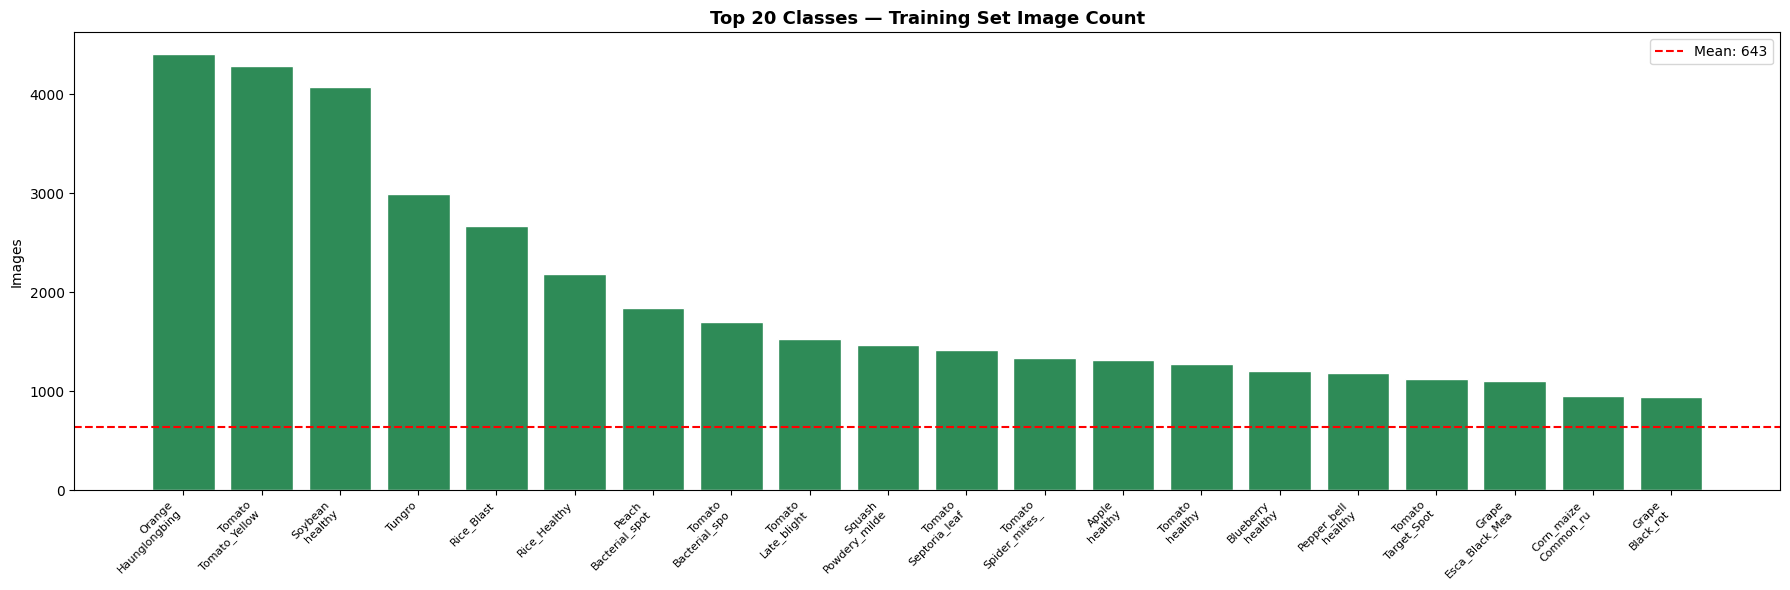


✅ Preprocessing Complete!
   Output saved to: ..\datasets\processed
   Next → 03_model_training.ipynb (Day 4-8)


In [9]:
# Top 20 classes by image count (train set)
class_counts = {}
for cls in TRAIN_DIR.iterdir():
    if cls.is_dir():
        class_counts[cls.name] = len(list(cls.iterdir()))

# Sort karo
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
top20          = sorted_classes[:20]

names  = [c[0].replace("___", "\n")[:20] for c in top20]
counts = [c[1] for c in top20]

plt.figure(figsize=(18, 6))
plt.bar(range(len(names)), counts, color='seagreen', edgecolor='white')
plt.xticks(range(len(names)), names, rotation=45, ha='right', fontsize=8)
plt.title("Top 20 Classes — Training Set Image Count", fontsize=13, fontweight='bold')
plt.ylabel("Images")
plt.axhline(y=np.mean(list(class_counts.values())), color='red',
            linestyle='--', label=f"Mean: {int(np.mean(list(class_counts.values())))}")
plt.legend()
plt.tight_layout()
plt.savefig("processed_distribution.png", dpi=150)
plt.show()

print(f"\n✅ Preprocessing Complete!")
print(f"   Output saved to: {OUTPUT_DIR}")
print(f"   Next → 03_model_training.ipynb (Day 4-8)")
